In [1]:
import sys
sys.path.append("..")
from pathlib import Path
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from statsmodels.nonparametric._kernel_base import gpke, _adjust_shape
from graphstructure.simple_substructure import SubstructureSimple, ConnectionBraces
from graphstructure.sample import SimpleConstraints
import json
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor

In [2]:
class ClassLocalOutlierFactor():
    def __init__(self) -> None:
        c = SimpleConstraints()
        self.brace_dict = ConnectionBraces.ordered_dict()
        self.N_BRACES = len(self.brace_dict)
        # the real structures are stored outside of the graphstructure package
        # with open(Path(__file__).parent.parent / "util/real_structures.json") as f:
        with open("real_structures.json") as f:
            real = json.load(f)

        self.max_layers = max([d["n_layers"] for d in real])

        encodings_real = [self.encode(d, one_hot=False) for d in real]
        X = np.array(encodings_real)

        self.df = pd.DataFrame(X, columns=self.transformed_columns)
        # self.instance_df = pd.DataFrame(columns=self.transformed_columns)
        # self.continuous = ["total_height", "radius_bottom", "radius_top"] + ["layer_height{}".format(i) for i in range(self.max_layers-2)]
        # self.ordered = ["legs", "n_layers"]
        # self.unordered = ["brace{}".format(i) for i in range(self.max_layers-1)] 

        print("Local Outlier Factor")
        # self.clf = IsolationForest(n_estimators=100, max_samples=256, n_jobs=11)
        self.clf = LocalOutlierFactor(novelty=True)

        self.clf.fit(self.df)

    def score(self):
        return(-1*np.array(self.clf.score_samples(self.df)))

    # from https://stackoverflow.com/questions/38592324/one-hot-encoding-using-numpy
    def get_one_hot(self, targets, nb_classes):
        res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
        return res.reshape(list(targets.shape)+[nb_classes])
    def encode(self, d, one_hot=True, native=False):
        basics = [d["legs"], d["total_height"], d["radius_bottom"], d["radius_top"], d["n_layers"]]

        # fill design's braces according to max_layers with dummies ("NONE")
        braces = d["connection_types"]
        if native:
            braces = np.array([b for b in braces] + ["NONE"] * (self.max_layers - 1 - len(braces)))
        else:
            braces = np.array([self.brace_dict[b] for b in braces] + [self.brace_dict["NONE"]] * (self.max_layers - 1 - len(braces)))
            if one_hot:
                braces = self.get_one_hot(braces, self.N_BRACES)

        # fill design's layer_heights according to max_layers with dummies
        layer_heights = d["layer_heights"]
        layer_heights = np.array(layer_heights + [d["total_height"]] * (self.max_layers - 2 - len(layer_heights))) / d["total_height"]
        self.transformed_columns = ["legs", "total_height", "radius_bottom", "radius_top", "n_layers"] + ["brace" + str(i) for i in range(len(braces.flatten()))] + ["layer_height" + str(i) for i in range(len(layer_heights))]

        to_return = np.array([*basics, *braces.flatten(), *layer_heights])
        # return a flat encoding

        return to_return

In [3]:
mif = ClassLocalOutlierFactor()

Local Outlier Factor


/home/luser/Kallikrates/venv/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/home/luser/Kallikrates/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/luser/Kallikrates/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


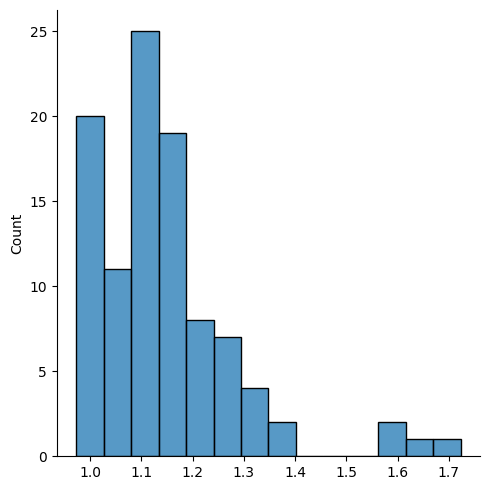

In [4]:
sns.displot(mif.score())